In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from network import create_model, create_dataloaders

In [2]:
# 检查PyTorch是否正确编译了CUDA
print(f"PyTorch是否编译了CUDA: {torch.cuda.is_available()}")
print(f"PyTorch CUDA版本: {torch.version.cuda}")

PyTorch是否编译了CUDA: True
PyTorch CUDA版本: 12.6


In [3]:
# 1. 选择训练方式
sizes = [128, 256, 512, 1024, 2048, 4096] # 基于符号长度进行训练

In [4]:
# 加载数据
X_train, y_train = {}, {}
X_test, y_test = {}, {}

for size in sizes:
    # 训练集
    df_train = shuffle(pd.read_csv(f'../preprocessed/combined_features_{size}.csv'), random_state=42)
    y_train = df_train['label']
    X_train = df_train.drop('label', axis=1).applymap(lambda x: complex(x)).values
    
    # 测试集
    df_test = shuffle(pd.read_csv(f'../preprocessed/combined_features_{size}_test.csv'), random_state=42)
    y_test = df_test['label']
    X_test = df_test.drop('label', axis=1).applymap(lambda x: complex(x)).values

C:\Users\Y\AppData\Local\Temp\ipykernel_225636\1864263499.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_train = df_train.drop('label', axis=1).applymap(lambda x: complex(x)).values
C:\Users\Y\AppData\Local\Temp\ipykernel_225636\1864263499.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_test = df_test.drop('label', axis=1).applymap(lambda x: complex(x)).values
C:\Users\Y\AppData\Local\Temp\ipykernel_225636\1864263499.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_train = df_train.drop('label', axis=1).applymap(lambda x: complex(x)).values
C:\Users\Y\AppData\Local\Temp\ipykernel_225636\1864263499.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_test = df_test.drop('label', axis=1).applymap(lambda x: complex(x)).values
C:\Users\Y\AppData\Local\Temp\ipykernel_225636\1864263499.py:9: FutureWarning: DataFrame.apply

In [5]:
# 2. 创建数据加载器
batch_size = 32
train_loader, test_loader, (scaler_real, scaler_imag) = create_dataloaders(X_train, y_train, X_test, y_test, batch_size)

In [6]:
# 3. 创建模型
num_features = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = create_model(num_features, num_classes)

In [7]:
# 4. 设置训练参数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 确保模型在GPU上
model = create_model(num_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

使用设备: cuda


In [8]:
# 5. 训练模型
num_epochs = 30
best_acc = 0.0

accuracies = []


for size in sizes:
    print(f"\n=== Training for items {size} ===")
    for epoch in range(1, num_epochs + 1):
        # 训练阶段
        model.train()
        total_loss = 0
        
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # 验证阶段
        model.eval()
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                _, predicted = torch.max(outputs.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y.cpu().numpy())
        
        acc = correct / total
        scheduler.step(acc)
        
        if acc > best_acc:
            best_acc = acc
            # 保存最佳模型
            # torch.save(model.state_dict(), f'./model_save/ComplexCNN_{size}.pth')
        
        print(f'Epoch {epoch}/{num_epochs}: Loss={total_loss/len(train_loader):.4f}, Acc={acc:.4f}, Best Acc={best_acc:.4f}')

    print(f"最终最佳准确率: {best_acc:.4f}")


=== Training for items 128 ===
Epoch 1/30: Loss=0.3175, Acc=0.8708, Best Acc=0.8708
Epoch 2/30: Loss=0.2321, Acc=0.9018, Best Acc=0.9018
Epoch 3/30: Loss=0.2216, Acc=0.9073, Best Acc=0.9073
Epoch 4/30: Loss=0.2082, Acc=0.9100, Best Acc=0.9100
Epoch 5/30: Loss=0.2053, Acc=0.9065, Best Acc=0.9100
Epoch 6/30: Loss=0.1990, Acc=0.9163, Best Acc=0.9163
Epoch 7/30: Loss=0.1900, Acc=0.9237, Best Acc=0.9237
Epoch 8/30: Loss=0.1907, Acc=0.9133, Best Acc=0.9237
Epoch 9/30: Loss=0.1904, Acc=0.9160, Best Acc=0.9237
Epoch 10/30: Loss=0.1910, Acc=0.9085, Best Acc=0.9237
Epoch 11/30: Loss=0.1805, Acc=0.9193, Best Acc=0.9237
Epoch 12/30: Loss=0.1687, Acc=0.9327, Best Acc=0.9327
Epoch 13/30: Loss=0.1629, Acc=0.9365, Best Acc=0.9365
Epoch 14/30: Loss=0.1641, Acc=0.9390, Best Acc=0.9390
Epoch 15/30: Loss=0.1597, Acc=0.9445, Best Acc=0.9445
Epoch 16/30: Loss=0.1571, Acc=0.9507, Best Acc=0.9507
Epoch 17/30: Loss=0.1557, Acc=0.9497, Best Acc=0.9507
Epoch 18/30: Loss=0.1546, Acc=0.9545, Best Acc=0.9545
Epoch

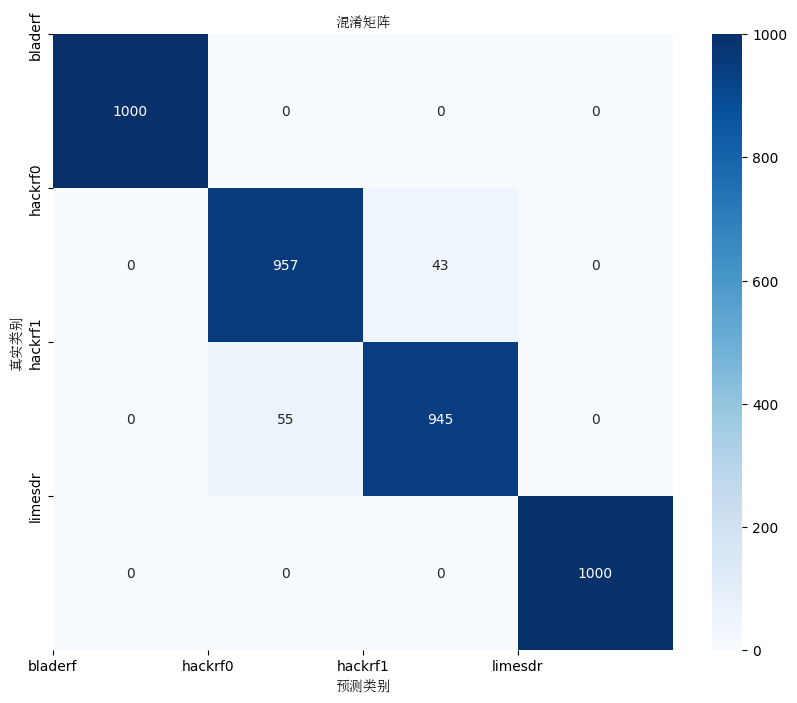

In [12]:
# 6. 绘制混淆矩阵（可选）
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('混淆矩阵', fontproperties="SimSun")
plt.ylabel('真实类别', fontproperties="SimSun")
plt.xlabel('预测类别', fontproperties="SimSun")
plt.xticks(range(4), ['bladerf', 'hackrf0', 'hackrf1', 'limesdr'])
plt.yticks(range(4), ['bladerf', 'hackrf0', 'hackrf1', 'limesdr'])
# plt.savefig(f'./img/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()